# Trigonometry

Very often in a radio we need to compute the magnitude or phase of a wave (represented in the complex domain). 

This can be expensive to do precisely, but approximations are usually good enough for our purposes.

Per usual, we should start off with some imports:

In [6]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from alldigitalradio.trig import MagnitudeApproximator
from alldigitalradio.io.numpy import make_callable, take_n

# Magnitude

Magnitude, or more formally "L2 Norm" requires squaring and square roots (and also addition, but that's cheap).

I found in some paper I've long forgotten an approximation I think pulled from a textbook that is implemented entirely with comparisons, adders and shifts.

To evaluate this, let's generate a sweep from zero to 2pi in the complex domain, with an increasing magnitude

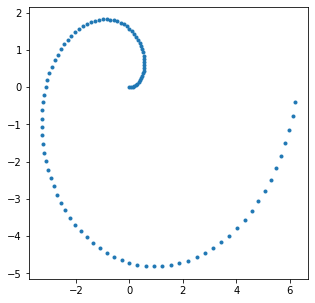

In [7]:
p = np.arange(0, 2*np.pi, 2*np.pi/100)              
inputs = p*np.exp(1j*p)
plt.figure(figsize=(5,5))
plt.plot(np.real(inputs), np.imag(inputs), '.')

Now let's push this through the `MagnitudeApproximator` and plot the approximate magnitude versus the actual magnitude

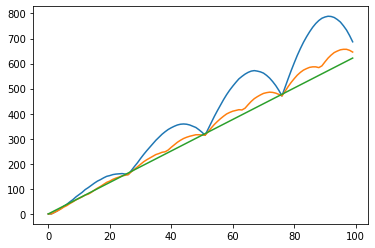

In [8]:
# (Blue) - First we'll use the simplest approximation, which is just an L1 norm
approximator = make_callable(MagnitudeApproximator(simple=True))
plt.plot([approximator(int(np.real(s)*100), int(np.imag(s)*100)) for s in inputs])

# (Orange) - Next we'll used the improved approximation (with the shifts and adds and comparisons)
approximator = make_callable(MagnitudeApproximator())
plt.plot([approximator(int(np.real(s)*100), int(np.imag(s)*100)) for s in inputs])

# (Green) Finally, the actual magnitude
plt.plot(np.abs(inputs*100))

All in all, we can see a decent amount of error, but the second (non-"simple" approach) is often correct enough for our purposes. When it's not, we have... CORDIC!

# CORDIC

Cordic is an old but brilliant algorithm to compute a variety of trigonometric functions using just shifts and adds. Let's talk through what it takes to compute an angle and magnitude with this technique.

Let's say you have a vector that you can visualize as going from the origin to (2,1) in (x,y) coordinates. The CORDIC approach to compute the magnitude and angle is to rotate this vector towards the x axis.  Depending on how far you need to rotate it, this tells you what the angle is. And once you've rotated it to the x-axis, the magnitude of the vector is just x because `sqrt(x*x + y*y)` when y is zero is just x.

But how much should we rotate it if we don't know the angle of the vector? The answer is to take a number of incremental steps towards the X axis, either clock-wise or counter-clockwise depending on if we're above or below the x-axis. With the right set of shrinking step-sizes we'll eventually converge on the X axis. To compute the angle, we sum up the combined rotations we did.

Now, rotation is a matrix multiplication, which requires... multiplication, normally by a `cos(theta)` and `sin(theta)` in a rotation matrix. However, if you are multiplying by a power of two you can instead just do a binary bit shift. It's not obvious that a pair of `sin` and `cos` for a given `theta` would _both_ be powers of two and that's because.. the wouldn't be.

What you can _instead_ do is divide the rotation matrix by `cos(theta)` (i.e. factor it out) and you'll be left with a matrix with only ones and `tan(theta)`. Then we choose step sizes (thetas) that result in `tan(theta)` that are powers of 2. Because `cos(theta)` is the same as `cos(-theta)`, no matter which direction we choose to go for a given step, this factor is the same -- which means it is a constant factor that can be ignored until a correction at the end. In many use cases where you only care about relative magnitude, you can skip this constant factor correction entirely.

OK, that's a wall of text, here's a pure python implementation:

## Python

In [16]:
def cordic(x, y, stages=10):
    # Cordic steps only sum up to about 90deg so for angles beyond that we need to add a bit of extra logic
    flip = False
    if x < 0:
        x = -x
        flip = True
    
    angle = 0
    K = 1

    for i in range(stages):
        K *= np.cos(np.arctan(2**-i))
        if y < 0:
            xn = x - y*2**-i
            yn = y + x*2**-i
            angle = angle - np.arctan(2**-i)
        else:
            xn = x + y*2**-i
            yn = y - x*2**-i
            angle = angle + np.arctan(2**-i)
            
        # Reduce the precision but also make things nicer to print
        x = xn
        y = yn
        
    angle = np.rad2deg(angle)
    if flip:
        angle = 180 - angle
    if angle < 0:
        angle += 360
    
    return x*K, angle

Let's compare this to the full-precision (correct) results:

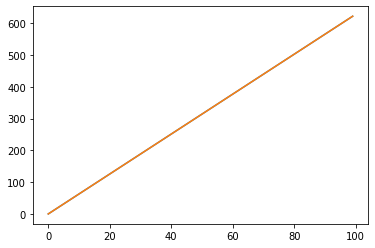

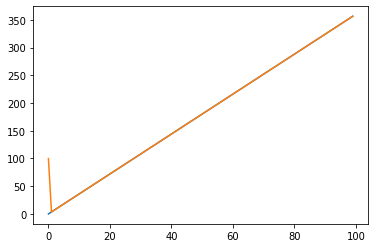

In [18]:
# Plot the magnitude
plt.plot(np.abs(inputs*100))
plt.plot([cordic(np.real(i), np.imag(i))[0] for i in inputs*100])
plt.show()

# Plot the angle (in degrees)
plt.plot(np.rad2deg(np.unwrap(np.angle(inputs*100))))
plt.plot([cordic(np.real(i), np.imag(i))[1] for i in inputs*100])

You'll note that at a small magnitude, we have a decent amout of error in the angle. This is because there aren't enough bits of precision in the coordinates for us to cleanly rotate the vector toward the X-axis (and indeed the angle for 0,0 is not well defined).

## nMigen

Since CORDIC is an iterative algorithm, it's very straightforward to pipeline. This trades resource usage for throughput, but in my use cases where I'm calculating magnitude/phase of signals at a pretty high sampling rate this is a worthwhile tradeoff.

In [11]:
from alldigitalradio.trig import Cordic

By varying the number of stages, we can print out the coordinates and angle at each iteration:

In [12]:
for n in range(10):
    c = Cordic(stages=n)
    c = make_callable(c, inputs=[c.input_x, c.input_y], outputs=[c.output_x, c.output_y, c.angle])
    x, y, angle = [c(30,60) for i in range(n+3)][-1]
    print(x, y, int(np.rad2deg(angle/2**14)))

30 60 0
90 30 11
105 -15 17
109 11 14
110 -2 16
111 4 15
111 1 15
111 0 15
111 0 16
111 0 16


Now let's compare this to our reference (note that I chop of the first `stages + 2` while the computations make their way through the pipeline)

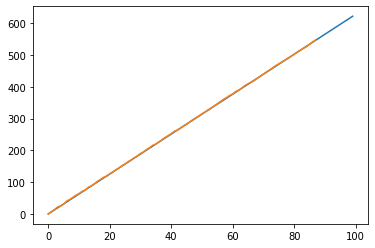

In [13]:
plt.plot(np.abs(inputs*100))

n = 10

# In this instance we're comparing against the real value so we need to multiply by the constant factor
k = 1
for i in range(n):
    k *= np.cos(np.arctan(2**-i))

c = Cordic(stages=n)
c = make_callable(c, inputs=[c.input_x, c.input_y], outputs=[c.output_x, c.output_y, c.angle])
plt.plot([c(int(np.real(i)*100), int(np.imag(i*100)))[0]*k for i in inputs][n + 2:])

Looking good! You might wonder how good/bad this works as a function of the number of stages. I gotchu fam:

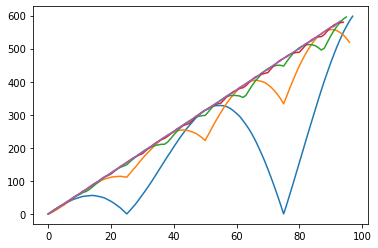

In [14]:
for n in range(5):
    # The constant factor varies depending on the number of stages so we
    # need to normalize our results with it to compare across stage-depth
    k = 1
    for i in range(n):
        k *= np.cos(np.arctan(2**-i))
        
    c = Cordic(stages=n)
    c = make_callable(c, inputs=[c.input_x, c.input_y], outputs=[c.output_x, c.output_y, c.angle])
    plt.plot([c(int(np.real(i)*100), int(np.imag(i*100)))[0]*k for i in inputs][n + 2:])

Now let's look at angles verify that this is correct as well

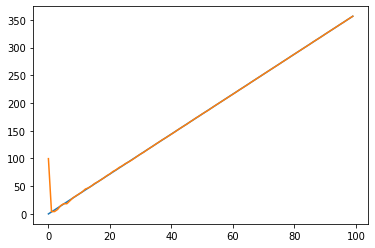

In [15]:
plt.plot(np.rad2deg(np.unwrap(np.angle(inputs*100))))

n = 10

c = Cordic(stages=n)
c = make_callable(c, inputs=[c.input_x, c.input_y], outputs=[c.output_x, c.output_y, c.angle])
plt.plot(np.rad2deg(([c(int(np.real(i)*100), int(np.imag(i*100)))[2]/(2**12) for i in np.concatenate((inputs, [0]*(n+2)))][n + 2:])))

Looks good!